In [1]:
import numpy as np
from scipy.spatial import distance
import scipy.integrate as integrate
from matplotlib import pyplot as plt

In [7]:
f = 0.01
A = np.array([[(1-f)**-1, 0],[0, 1-f]])

class Point:
    def __init__(self, n, x):
        self.n = n
        self.x = x
    
    def __str__(self):
        return "<n: %i x: %s>" % (self.n, str(self.x))
    
    def __repr__(self):
        return self.__str__()

class Run:
    
    def __init__(self):
        self.f      = 0.0
        self.sigma  = 0.2
        self.A      = np.array([[(1-self.f)**-1, 0],[0, 1-self.f]])
        self.X      = [Point(1, np.array([0.1, 0.1]))]
        self.n_min  = 1e-6
        self.n_init = 1e-6
        
        self.mu     = 2e-7
        self.eps    = 5e-3
        
        self.grid_fineness = 6
        
        self.time    = 0
        #self.history = []
        self.points  = set()
        
        self.n = np.array([1])
        self.x = np.array([[0.1, 0.1]])
    
    def b(self, x):
        return 1 - np.dot(np.dot(A, x),x)
    
    def a(self, x, y):
        return np.exp(-np.dot(x-y, x-y) / (2 * self.sigma**2))
    
    def I(self, x):
        return sum((p.n * self.a(p.x,y) for p in self.X))
    
    def generate_nearby_point(self, x):
        random_point = (np.random.random(x.shape) * 2 - 1) * self.eps
        
        if np.linalg.norm(random_point) > self.eps:
            return self.generate_nearby_point(x)
        
        return x + random_point.round(self.grid_fineness)
    
    def step(self):
        for p in self.X:
            p.n += (self.b(p.x) - self.I(p.x)) * p.n
        
        self.X = [p for p in self.X if p.n >= self.n_min]
        
        if self.time % 100 == 0:
            for p in self.X:
                if np.random.random() < self.mu * self.b(p.x) * p.n*100:
                    p.n  -= self.n_init
                    self.X.append(Point(self.n_init, self.generate_nearby_point(p.x)))
        
        self.time += 1
        if self.time % 100 == 0:
        #    self.history.append(self.X)
            self.points |= set([tuple(p.x) for p in self.X])

In [91]:
sigma = 0.2

In [108]:
n = np.array([1, 2, 3, 4])
x = np.array([[0.1, 0.1], [0, 0], [0.3, -0.1], [0.5, 0.7]])

In [111]:
b = 1 - np.einsum("ik, kl, il->i", x, A, x)
print("b: ", b)

dist2 = distance.squareform(distance.pdist(x, "sqeuclidean"))
a     = np.exp(-dist2 / (2 * sigma**2))
print("a:")
print(a)

I = np.dot(a, n)
(b - I) * n

b:  [0.97999899 1.         0.89919091 0.26237475]
a:
[[1.00000000e+00 7.78800783e-01 3.67879441e-01 1.50343919e-03]
 [7.78800783e-01 1.00000000e+00 2.86504797e-01 9.61116521e-05]
 [3.67879441e-01 2.86504797e-01 1.00000000e+00 2.03468369e-04]
 [1.50343919e-03 9.61116521e-05 2.03468369e-04 1.00000000e+00]]


array([ -2.68725466,  -5.27739924,  -9.127536  , -14.95972528])

In [120]:
class Run:
    
    def __init__(self):
        self.f      = 0.0
        self.sigma  = 0.2
        self.A      = np.array([[(1-self.f)**-1, 0],[0, 1-self.f]])
        self.n_min  = 1e-6
        self.n_init = 1e-6
        
        self.mu     = 2e-7
        self.eps    = 5e-3
        
        self.grid_fineness = 5
        
        self.time      = 0
        self.last_time = 0
        #self.history  = []
        self.points    = set()
        
        self.n = np.array([1e-6])
        self.x = np.array([[0.1, 0.1]])
        
        self.generate_b_vector_and_a_matrix()
    
    def generate_nearby_point(self, x):
        random_point = (np.random.random(x.shape) * 2 - 1) * self.eps
        
        if np.linalg.norm(random_point) > self.eps:
            return self.generate_nearby_point(x)
        
        return x + random_point.round(self.grid_fineness)
    
    def generate_b_vector_and_a_matrix(self):
        self.b = 1 - np.einsum("ik, kl, il->i", self.x, self.A, self.x)
        
        dist2  = distance.squareform(distance.pdist(self.x, "sqeuclidean"))
        self.a = np.exp(-dist2 / (2 * self.sigma**2))
    
    def get_derivative(self, y, t):
        n, sum_n = np.split(y, 2)
        I = np.dot(self.a, n)
        return np.hstack(((self.b - I) * n, n))
    
    def mutate(self, sum_n):
        new_species = False
        
        chances = self.mu * self.b * sum_n * 100
        randoms = np.random.random(chances.shape)
        
        mutation_indices = np.where(randoms < chances)[0]
        
        for ind in mutation_indices:
            self.n[ind] -= self.n_init
            new_pos = self.generate_nearby_point(self.x[ind])
            self.x = np.vstack((self.x, new_pos))#check
            self.n = np.hstack((self.n, self.n_init))#check
            
            new_species = True
            self.points.add(tuple(new_pos))
        
        if new_species:
            self.generate_b_vector_and_a_matrix()
    
    def die_out(self, sum_n):
        keep_indices = self.n >= self.n_min
        
        if not np.all(keep_indices):
            self.n = self.n[keep_indices]
            self.x = self.x[keep_indices]
            sum_n  = sum_n [keep_indices]
            
            self.generate_b_vector_and_a_matrix()
        
        return sum_n
    
    def step(self):
        y0 = np.hstack((self.n, np.zeros_like(self.n)))
        result_vector = integrate.odeint(self.get_derivative, y0, [self.time, self.time+100])[1]
        self.n, sum_n = np.split(result_vector, 2)
        
        sum_n = self.die_out(sum_n)
        self.mutate(sum_n)
        
        
        self.time += 100

In [121]:
r.n

array([8.13619287e-01, 2.80168106e-04, 3.07986908e-04, ...,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06])

In [122]:
r.a

array([[1.        , 0.99563662, 0.995371  , ..., 0.98922733, 0.99317367,
        0.98084764],
       [0.99563662, 1.        , 0.99972534, ..., 0.99759839, 0.99126025,
        0.98386368],
       [0.995371  , 0.99972534, 1.        , ..., 0.99605617, 0.9883471 ,
        0.98774946],
       ...,
       [0.98922733, 0.99759839, 0.99605617, ..., 1.        , 0.99210369,
        0.9714058 ],
       [0.99317367, 0.99126025, 0.9883471 , ..., 0.99210369, 1.        ,
        0.95635604],
       [0.98084764, 0.98386368, 0.98774946, ..., 0.9714058 , 0.95635604,
        1.        ]])

In [129]:
r = Run()
for _ in range(100000):
    r.step()

print(r.x)
print(r.n)

[[ 0.12691  0.01407]
 [-0.01422  0.08754]
 [-0.01486  0.08649]]
[5.55912534e-01 5.87017828e-01 3.32709606e-06]


<IPython.core.display.Javascript object>


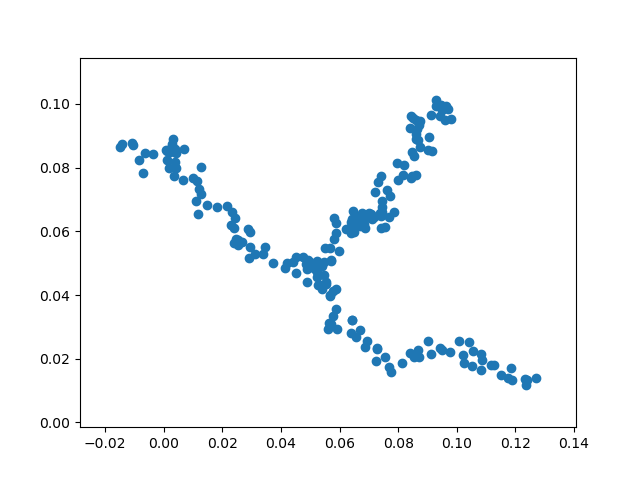

In [130]:
points = np.array([list(x) for x in r.points])
plt.figure()
plt.scatter(points[:, 0], points[:, 1]);

In [26]:
asd = np.zeros((100,100))
for i, x in enumerate(np.linspace(-1, 1, 100)):
    for j, y in enumerate(np.linspace(-1, 1, 100)):
        X = np.array([x,y])
        asd[i, j] = b(X)

NameError: name 'b' is not defined

<IPython.core.display.Javascript object>


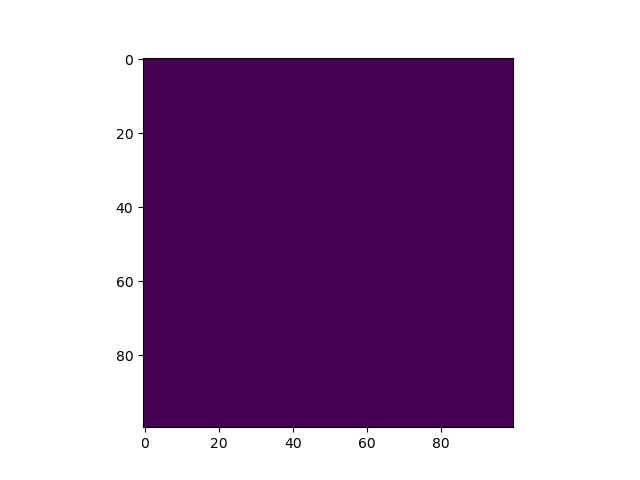

In [27]:
plt.figure()
plt.imshow(asd)

In [24]:
%matplotlib notebook

<IPython.core.display.Javascript object>


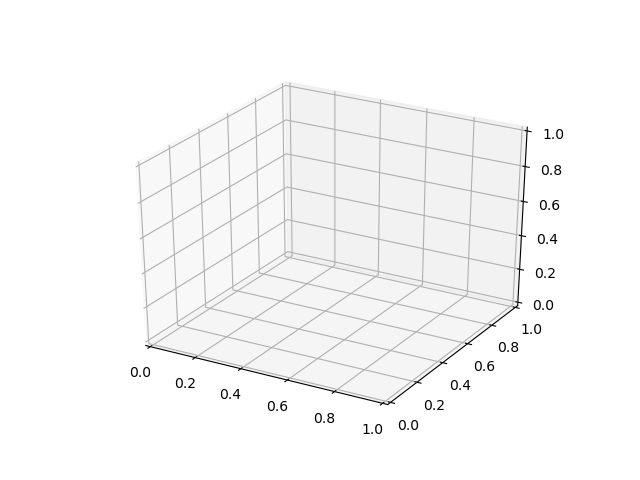

NameError: name 'asd' is not defined

In [25]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

grids = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
ax.plot_surface(grids[0], grids[1], asd)